# Traffic Accident Risk Forecasting with Time Series

This notebook implements location-specific accident probability forecasting using time series methods.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import prince

# Time series specific imports
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Geospatial
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import pymc as pm

from tqdm import tqdm

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.5f}'.format)


import pickle
def save_pkl(data, filepath):
    """
    Pickles the provided data into the filepath
    """
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

def load_pkl(filepath):
    """
    De-serializes the pkl file
    """
    with open(filepath, "rb") as f:
        return pickle.load(f)
    
import os
try:
    if run_once == False:
        pass
    else:
        print("os.chdir('..') already run once -- will not run again")
except:
    run_once = True
    os.chdir("..")

In [ ]:
df = pd.read_csv("./data/merged.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()

In [ ]:
weather_df = pd.read_csv("./data/weather_data.csv")
weather_df["datetime"] = pd.to_datetime(weather_df["datetime"])
weather_df = weather_df.set_index("datetime")
weather_df.head()

,temp,visibility,feels_like,temp_min,temp_max,wind_speed,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,visibility_category,rain_1h_category,rain_3h_category,snow_1h_category,snow_3h_category,wind_intensity
datetime,,,,,,,,,,,,,,,,,,,,,
2012-12-31 19:00:00,3.06000,10000.00000,-2.60000,2.71000,3.25000,8.74000,12.85000,0.00000,0.00000,0.00000,0.00000,100,804,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind
2012-12-31 20:00:00,3.07000,10000.00000,-1.84000,3.01000,3.93000,6.68000,11.82000,0.00000,0.00000,0.00000,0.00000,100,804,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind
2012-12-31 21:00:00,3.07000,10000.00000,-1.84000,3.01000,3.93000,6.68000,9.77000,0.00000,0.00000,0.00000,0.00000,100,804,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind
2012-12-31 22:00:00,3.38000,10000.00000,-1.83000,3.15000,4.35000,7.71000,12.85000,0.00000,0.00000,0.00000,0.00000,100,804,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind
2012-12-31 23:00:00,3.38000,10000.00000,-2.01000,3.15000,4.35000,8.22000,12.85000,0.00000,0.00000,0.00000,0.00000,100,804,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind


## Step 1: Create Spatial Grid for Locations

We'll create a grid-based approach to define "locations" for forecasting. This allows us to:
- Aggregate accidents within geographic cells
- Create consistent time series for each location
- Scale to different resolution levels

### 1.1 Visualizing Coordinates

By cleaning our data, we guarantee that all points have coordinate locations

We then plot the coordinates to ensure that we don't have any outlier locations, i.e., points that aren't inherently in NYC.

It's also nice to look at how it shapes out the city and its streets :)

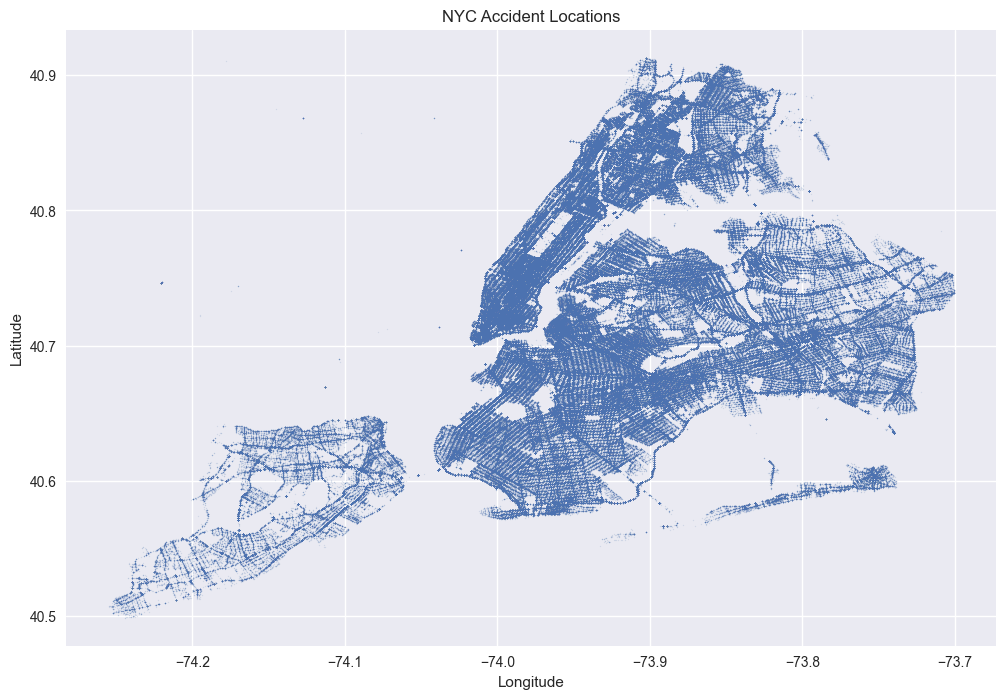

Longitude range: -74.254960 to -73.700550
Latitude range: 40.498947 to 40.912884


In [ ]:
# First, let's examine the spatial distribution
plt.figure(figsize=(12, 8))
plt.scatter(df['longitude'], df['latitude'], alpha=0.1, s=0.5)
plt.title('NYC Accident Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Check coordinate ranges
print(f"Longitude range: {df['longitude'].min():.6f} to {df['longitude'].max():.6f}")
print(f"Latitude range: {df['latitude'].min():.6f} to {df['latitude'].max():.6f}")

We can see that there are clear

### 1.2 Spatial Grid

We group the locations into square grids of `0.05 degrees` x `0.05 degrees`.

Of course, smaller grid sizes would be preferable, especially in a densely populated area like NYC. However, given the large amount of data, any increased granularity will blow up the memory and runtime (we will eventually have ***100,000 datapoints per grid location***, which we will explain later)

In [ ]:
def create_spatial_grid(df, bin_size: float = 0.01):
    """
    Create spatial grid cells for aggregating accidents.
    grid_size: degrees (approximately 1km = 0.01 degrees)
    """
    # Remove rows with missing coordinates
    df_clean = df.dropna(subset=['latitude', 'longitude']).copy()
    
    # Create grid coordinates
    df_clean['grid_lat'] = ((df_clean['latitude'] / bin_size).round() * bin_size).round(3)
    df_clean['grid_lon'] = ((df_clean['longitude'] / bin_size).round() * bin_size).round(3)
    
    # Create location identifier
    df_clean['location_id'] = df_clean['grid_lat'].astype(str) + '_' + df_clean['grid_lon'].astype(str)
    
    return df_clean

# Create spatial grid (0.01 degrees ≈ 1km)
df_spatial = create_spatial_grid(df, bin_size=0.05)

print(f"Number of unique grid locations: {df_spatial['location_id'].nunique()}")
print(f"Accidents with valid coordinates: {len(df_spatial)}")

# Show location distribution
location_counts = df_spatial['location_id'].value_counts()
print(f"\nTop 10 locations by accident count:")
print(location_counts.head(10))

Number of unique grid locations: 71
Accidents with valid coordinates: 1897041

Top 10 locations by accident count:
location_id
40.75_-74.0     146648
40.7_-74.0      126031
40.7_-73.95     105810
40.85_-73.9     102696
40.8_-73.95      95115
40.65_-73.95     93692
40.75_-73.95     83638
40.65_-73.9      79139
40.75_-73.9      75259
40.7_-73.9       69928
Name: count, dtype: int64


## Step 2: Exploratory Data Analysis

Let's explore which factors may be of interest to us.

We will:

1.  Explore correspondence analysis between count data of categorical weather factors between accidents and the overall weather data.

### Step 2.1: Correspondence Analysis

In [ ]:
weather_columns = ["visibility_category", "rain_1h_category", "snow_1h_category", "wind_intensity"]

def get_count_data(pd_df: pd.DataFrame, columns: list[str] = weather_columns, normalize=False) -> pd.DataFrame:
    """
    Retrieves count data of the provided dataframe and columns,
    returns the resulting table
    """
    result = pd.DataFrame()
    
    pd_df_columns = pd_df[columns]
    
    for col in columns:
        # Get unique values for each column
        count_values = pd_df_columns[col].value_counts(normalize=normalize)
        for value, count in count_values.items():
            if value == np.nan or value == "nan":
                continue
            result = pd.concat([result, pd.DataFrame({
                'value': [value],
                'freq': [count]
            })], ignore_index=True)
        

    return result

# Get accident rate data
accident_rate_data = get_count_data(df_spatial, weather_columns, normalize=True)

# Get weather rate data
weather_rate_data = get_count_data(weather_df, weather_columns, normalize=True)

weather_rate_data

,value,freq
0,High Visibility,0.94401
1,Medium Visibility,0.05167
2,Low Visibility,0.00432
3,No Rain,0.84199
4,Light Rain,0.14415
5,Moderate Rain,0.01296
6,Heavy Rain,0.00091
7,No Snow,0.98832
8,Light Snow,0.00920
9,Moderate Snow,0.00231


In [ ]:
accident_pivot = accident_rate_data.set_index('value')['freq']
weather_pivot = weather_rate_data.set_index('value')['freq']
contingency = pd.DataFrame({
    'incidents': accident_pivot,
    'weather': weather_pivot
}).fillna(0)

import altair as alt

fig = plt.figure(figsize=(12, 12))
ca = prince.CA(n_components=1)
ca = ca.fit(contingency)
chart = ca.plot(contingency, show_row_labels=True, show_column_labels=True, x_component=0, y_component=0)
chart = chart.configure_text(
    fontSize=12,     # Override text size specifically
    font='Monospace'     # Change font family
).properties(
    width=800,
    height=600
).configure_axis(
    labelFontSize=16,
    labelFont='Monospace',
    titleFont='Monospace',
    titleFontSize=20,
    titleAlign='center'
).properties(
    title = alt.Title(text="Correspondence Analysis of Weather Conditions and Accident Incidents", fontSize=20, font="Monospace"),
)
chart

alt.LayerChart(...)

<Figure size 1200x1200 with 0 Axes>

We can visualize the association between typical weather conditions and the weather conditions at the times of vehicle incidents (seen by the ***weather*** point in the bottom-left corner and the ***incidents*** point above).

Points farther up (e.g., ***Low Visibility***, ***Very Strong Wind***, ***Heavy Snow***, ***Moderate Snow***) represent higher risks of incidents.

Let's break down the various weather categories:

&emsp; `Snow`: There is a clear gradient:

&emsp;&emsp;&emsp;- ***No Snow***: 0

&emsp;&emsp;&emsp;- ***Light Snow***: 0.07

&emsp;&emsp;&emsp;- ***Moderate Snow***: 0.24

&emsp;&emsp;&emsp;- ***Heavy Snow***: 0.22

&emsp; `Visibility`: There is a clear gradient:

&emsp;&emsp;&emsp;- ***High Visibility***: -0.02, near typical weather conditions

&emsp;&emsp;&emsp;- ***Medium Visibility***: 0.01, near 'incident'

&emsp;&emsp;&emsp;- ***Low Visibility***: 0.17

&emsp; `Rain` There is a curious pattern with rain, where:

&emsp;&emsp;&emsp;- ***No Rain***: ~ 0

&emsp;&emsp;&emsp;- ***Light Rain***: 0.04

&emsp;&emsp;&emsp;- ***Moderate Rain*** ~ 0.09

&emsp;&emsp;&emsp;- ***Heavy Rain*** ~ 0.01

&emsp;&emsp;&emsp;We see an odd occurrence, where ***Heavy Rain*** isn't associated with higher incident risks.

&emsp; `Wind`: Wind displays a clear gradient from ***Very Strong Wind***

&emsp;&emsp;&emsp;- ***Light Wind***: -0.02

&emsp;&emsp;&emsp;- ***Moderate Wind***: 0.05

&emsp;&emsp;&emsp;- ***Strong Wind***: 0.05

&emsp;&emsp;&emsp;- ***Very Strong Wind***: 0.14

## Step 3: Time Series Aggregation

We would like our data in an aggregated format for each grid location.

Our current DataFrame only consists of entries of accidents. We would like to have full hourly coverage, and sum the number of accidents within each hour.

By doing so, we will have ***about 100,000 rows per location*** (about 102,479 hours from 2013 to Sept 9, 2025, the time I'm writing this).

In [ ]:
def create_time_series_data(df, weather_df, time_freq='H', min_accidents=50):
    """
    Create time series dataset from accident data.
    
    Args:
        df (pd.DataFrame): accidents dataframe
        weather_df (pd.DataFrame): weather dataframe (for filling empty time values)
        time_freq: pandas frequency string ('H' for hourly, 'D' for daily)
        min_accidents: minimum total accidents per location to include
    """
    # Filter locations with sufficient data
    location_counts = df['location_id'].value_counts()
    valid_locations = location_counts[location_counts >= min_accidents].index # filter out the bins below min_accidents
    df_filtered = df[df['location_id'].isin(valid_locations)].copy() # get rows where the location is within a filtered bin
    
    print(f"Locations with >= {min_accidents} accidents: {len(valid_locations)}")
    
    # Create time series by location
    time_series_data = []
    
    for location in tqdm(valid_locations, desc="Aggregating locations..."):
        location_data = df_filtered[df_filtered['location_id'] == location].copy() # get the location's data
        
        # Aggregate by time period
        ts = location_data.set_index('datetime').resample(time_freq).agg({
            'collision_id': 'count',  # accident count
            'number_of_persons_injured': 'sum',
            'number_of_persons_killed': 'sum',
            'grid_lat': 'first',
            'grid_lon': 'first'
        }).rename(columns={'collision_id': 'accident_count'})
        
        # Fill the missing time periods with the existing weather data
        # Left join on the times
        ts = ts.merge(weather_df, left_index=True, right_index=True, how="left")
        ts['grid_lon'] = ts['grid_lon'].fillna(method="ffill")
        ts['grid_lat'] = ts['grid_lat'].fillna(method="ffill")
        ts['location_id'] = location
        time_series_data.append(ts)
    
    return time_series_data, valid_locations

# Create hourly time series data
ts_data, valid_locations = create_time_series_data(df_spatial, weather_df, time_freq='H', min_accidents=100)

print(f"Created time series for {len(ts_data)} locations")
print(f"Sample location time series shape: {ts_data[0].shape}")
ts_data[0].head()

Locations with >= 100 accidents: 56


Aggregating locations...: 100%|██████████| 56/56 [00:09<00:00,  5.77it/s]


Created time series for 56 locations
Sample location time series shape: (110237, 27)


,accident_count,number_of_persons_injured,number_of_persons_killed,grid_lat,grid_lon,temp,visibility,feels_like,temp_min,temp_max,wind_speed,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,visibility_category,rain_1h_category,rain_3h_category,snow_1h_category,snow_3h_category,wind_intensity,location_id
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-31 19:00:00,3,0,0,40.75000,-74.00000,3.06000,10000.00000,-2.60000,2.71000,3.25000,8.74000,12.85000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind,40.75_-74.0
2012-12-31 20:00:00,1,0,0,40.75000,-74.00000,3.07000,10000.00000,-1.84000,3.01000,3.93000,6.68000,11.82000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind,40.75_-74.0
2012-12-31 21:00:00,3,0,0,40.75000,-74.00000,3.07000,10000.00000,-1.84000,3.01000,3.93000,6.68000,9.77000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind,40.75_-74.0
2012-12-31 22:00:00,2,0,0,40.75000,-74.00000,3.38000,10000.00000,-1.83000,3.15000,4.35000,7.71000,12.85000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind,40.75_-74.0
2012-12-31 23:00:00,0,0,0,40.75000,-74.00000,3.38000,10000.00000,-2.01000,3.15000,4.35000,8.22000,12.85000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind,40.75_-74.0


We would like to merge the DataFrame into a single one. This makes it easier for future processing.

We use the grid location as an identifier.

In [ ]:
def merge_ts_data(df_list: list[pd.DataFrame], valid_locations: list[str]) -> pd.DataFrame:
    """Merges the lists into a single DataFrame"""
    all_data = []
    
    for i, (ts_df, location_id) in tqdm(enumerate(zip(df_list, valid_locations)), desc="Merging to single DataFrame...", total=len(df_list)):
        # Work on a copy of the individual DataFrame
        df_copy = ts_df.copy()
        df_copy["bin_id"] = i
        df_copy["location_id"] = location_id
        df_copy["datetime"] = df_copy.index
        df_copy["hour_index"] = range(len(df_copy))
        df_copy["x_bin"] = df_copy["grid_lon"].iloc[0]
        df_copy["y_bin"] = df_copy["grid_lat"].iloc[0]
        
        all_data.append(df_copy)  # Append the modified copy
    
    merged_df = pd.concat(all_data, ignore_index=True)
    return merged_df


merged_ts_df = merge_ts_data(ts_data, valid_locations).dropna()

Merging to single DataFrame...: 100%|██████████| 56/56 [00:01<00:00, 29.32it/s]


In [ ]:
merged_ts_df.sample(5)

,accident_count,number_of_persons_injured,number_of_persons_killed,grid_lat,grid_lon,temp,visibility,feels_like,temp_min,temp_max,wind_speed,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,visibility_category,rain_1h_category,rain_3h_category,snow_1h_category,snow_3h_category,wind_intensity,location_id,bin_id,datetime,hour_index,x_bin,y_bin
4750544,0,0,0,40.85000,-73.80000,10.65000,10000.00000,9.13000,9.93000,11.15000,9.77000,15.26740,0.00000,0.00000,0.00000,0.00000,20.00000,801.00000,Clouds,few clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind,40.85_-73.8,43,2014-04-08 23:00:00,11035,-73.80000,40.85000
4060150,0,0,0,40.75000,-73.70000,18.85000,10000.00000,18.80000,18.15000,19.52000,4.63000,7.23521,0.00000,0.00000,0.00000,0.00000,0.00000,800.00000,Clear,sky is clear,High Visibility,No Rain,No Rain,No Snow,No Snow,Light Wind,40.75_-73.7,36,2023-06-29 05:00:00,91946,-73.70000,40.75000
452809,0,0,0,40.80000,-73.95000,15.09000,1207.00000,15.14000,12.18000,15.21000,2.60000,4.06297,0.00000,0.00000,0.00000,0.00000,100.00000,701.00000,Mist,mist,Medium Visibility,No Rain,No Rain,No Snow,No Snow,Light Wind,40.8_-73.95,4,2014-05-10 02:00:00,11863,-73.95000,40.80000
5671175,0,0,0,40.80000,-73.75000,4.13000,10000.00000,-0.29000,3.93000,4.35000,6.20000,9.68862,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Rain,No Snow,No Snow,Moderate Wind,40.8_-73.75,51,2018-11-21 01:00:00,51605,-73.75000,40.80000
2645075,0,0,0,40.65000,-73.75000,26.99000,10000.00000,28.84000,26.10000,27.93000,4.12000,6.43825,0.25000,0.25000,0.00000,0.00000,20.00000,500.00000,Rain,light rain,High Visibility,Light Rain,Light Rain,No Snow,No Snow,Light Wind,40.65_-73.75,23,2025-07-09 23:00:00,109757,-73.75000,40.65000


### Checkpoint

In [ ]:
save_pkl(merged_ts_df, "./data/aggregated_50bins.csv")

## Step 4: Feature Engineering

In [2]:
merged_ts_df = load_pkl("./data/aggregated_50bins.csv")

### Step 4.1: Temporal Features

We would like to create temporal features to include potentially significant factors. This includes:

- the hour of the day (e.g., midnight is less likely than 8 AM rush hour)

- whether or not it's rush hour

- the day of the year (e.g., no school during summer -> potentially less traffic (seasonal patterns))

In [3]:
def add_temporal_features(ts_df):
    """Add temporal features to time series dataframe."""
    ts_df = ts_df.copy()
    
    # Extract time components
    # ts_df['hour'] = ts_df.index.hour
    # ts_df['is_weekend'] = (ts_df.index.dayofweek >= 5).astype(int)
    # day_of_year = ts_df.index.dayofyear
    dt = ts_df["datetime"].dt
    
    ts_df['hour'] = dt.hour
    ts_df['is_weekend'] = (dt.dayofweek >= 5).astype(int)
    day_of_year = dt.dayofyear
    
    # Rush hour indicators
    ts_df['is_morning_rush'] = ((ts_df['hour'] >= 7) & (ts_df['hour'] <= 9)).astype(int)
    ts_df['is_evening_rush'] = ((ts_df['hour'] >= 17) & (ts_df['hour'] <= 19)).astype(int)
    ts_df['is_rush_hour'] = (ts_df['is_morning_rush'] | ts_df['is_evening_rush']).astype(int)
    
    # Seasonal features
    ts_df['sin_hour'] = np.sin(2 * np.pi * ts_df['hour'] / 24)
    ts_df['cos_hour'] = np.cos(2 * np.pi * ts_df['hour'] / 24)
    ts_df['sin_day'] = np.sin(2 * np.pi * day_of_year / 365)
    ts_df['cos_day'] = np.cos(2 * np.pi * day_of_year / 365)
    
    return ts_df

# Add temporal features
merged_featured = add_temporal_features(merged_ts_df)

print("Added temporal features to all locations")
print("Sample features:")
print(merged_featured[['accident_count', 'hour', 'is_rush_hour', 'temp']].head(10))

Added temporal features to all locations
Sample features:
   accident_count  hour  is_rush_hour    temp
0               3    19             1 3.06000
1               1    20             0 3.07000
2               3    21             0 3.07000
3               2    22             0 3.38000
4               0    23             0 3.38000
5               2     0             0 3.39000
6               1     1             0 4.14000
7               4     2             0 3.38000
8               1     3             0 4.14000
9               4     4             0 4.14000


### Step 4.2: Rescaling Features

We would like to standardize our features:

- Log transformation for ***visibility***

    - A change from 100m visibility to 200m is much more significant than from 5000m to 5100m. Thus, a log scale would likely be preferred.

- Standardization for ***rain, snow, wind*** measurements

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

def rescale_features(ts_df: pd.DataFrame):
    """Rescales features for improved learning"""
    # Log transform visibility
    df = ts_df.copy()
    df["log10_visibility"] = np.log10(df["visibility"])
    
    # Normalize rain
    rain_scaler = RobustScaler()
    df["normalized_rain"] = rain_scaler.fit_transform(df[["rain_1h"]])
    
    # Normalize snow
    snow_scaler = RobustScaler()
    df["normalized_snow"] = snow_scaler.fit_transform(df[["snow_1h"]])
    
    # Normalize wind gusts
    wind_scaler = RobustScaler()
    df["normalized_wind_gust"] = wind_scaler.fit_transform(df[["wind_gust"]])
    
    return df

In [5]:
merged_featured_rescaled = rescale_features(merged_featured)

In [ ]:
merged_featured_rescaled[["normalized_rain", "normalized_snow", "normalized_wind_gust", "log10_visibility"]].describe()

,normalized_rain,normalized_snow,normalized_wind_gust,log10_visibility
count,6165771.00000,6165771.00000,6165771.00000,6165771.00000
mean,0.15826,0.00814,0.10688,3.96376
std,0.82303,0.11648,0.81163,0.14081
min,0.00000,0.00000,-1.56885,2.30320
25%,0.00000,0.00000,-0.41401,4.00000
50%,0.00000,0.00000,0.00000,4.00000
75%,0.00000,0.00000,0.58599,4.00000
max,36.58000,5.80000,5.75373,4.00000


We see that the rain still has extremely large outliers. We should consider windsorization (capping extreme outliers at a fixed percentile) before standardization.

In [6]:
from scipy.stats import mstats
def winsorize_features(df: pd.DataFrame, lower_pct = 0.01, upper_pct = 0.997):
    """Windsorizes extreme outliers in data"""
    df = df.copy()
    cols = ["rain_1h"]
    for col in cols:
        if col in df.columns:
            original_max = df[col].max()
            df[col] = mstats.winsorize(df[col], limits=[lower_pct, 1 - upper_pct])
            
            print(f"{col}:")
            print(f"  Original max: {original_max:.2f}")
            print(f"  Winsorized max: {df[col].max():.2f}")
            print(f"  99.5th percentile: {df[col].quantile(0.995):.2f}")
            
    return df

cols = ["rain_1h"]
winsorized_features = winsorize_features(merged_featured)
print(winsorized_features[cols].describe())

rain_1h:
  Original max: 36.58
  Winsorized max: 6.01
  99.5th percentile: 4.57
            rain_1h
count 6165771.00000
mean        0.14502
std         0.57872
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max         6.01000


Now we can standardize our features

In [7]:
df_standardized = rescale_features(winsorized_features)
df_standardized[["normalized_rain", "normalized_snow", "normalized_wind_gust", "log10_visibility"]].describe()

,normalized_rain,normalized_snow,normalized_wind_gust,log10_visibility
count,6165771.00000,6165771.00000,6165771.00000,6165771.00000
mean,0.14502,0.00814,0.10688,3.96376
std,0.57872,0.11648,0.81163,0.14081
min,0.00000,0.00000,-1.56885,2.30320
25%,0.00000,0.00000,-0.41401,4.00000
50%,0.00000,0.00000,0.00000,4.00000
75%,0.00000,0.00000,0.58599,4.00000
max,6.01000,5.80000,5.75373,4.00000


### Step 4.2.1 One-Hot Encoding Features

Because we observed some interesting patterns in the ***Correspondence Analysis (see Step 2)***, we should consider one-hot encoding our data to account for potential nonlinear patterns.

- For example, ***Heavy Rain*** exhibited less inherent 'risk' than ***Moderate Rain***. Because of this observation, one-hot encoding, while typically not advisable for ordinal and numerical factors, can be a reasonable approach to ignore the ordinal structure and potentially learn these nonlinear patterns

In [8]:
def onehot_encode_features(df: pd.DataFrame, cols: list[str]):
    """One-hot encodes the given columns"""
    return pd.get_dummies(df, columns=cols, dtype=int)

df_encoded = onehot_encode_features(df_standardized, cols=["snow_1h_category", "rain_1h_category", "wind_intensity"])
    

In [9]:
df_encoded

,accident_count,number_of_persons_injured,number_of_persons_killed,grid_lat,grid_lon,temp,visibility,feels_like,temp_min,temp_max,wind_speed,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,visibility_category,rain_3h_category,snow_3h_category,location_id,bin_id,datetime,hour_index,x_bin,y_bin,hour,is_weekend,is_morning_rush,is_evening_rush,is_rush_hour,sin_hour,cos_hour,sin_day,cos_day,log10_visibility,normalized_rain,normalized_snow,normalized_wind_gust,snow_1h_category_Heavy Snow,snow_1h_category_Light Snow,snow_1h_category_Moderate Snow,snow_1h_category_No Snow,rain_1h_category_Heavy Rain,rain_1h_category_Light Rain,rain_1h_category_Moderate Rain,rain_1h_category_No Rain,wind_intensity_Calm,wind_intensity_Light Wind,wind_intensity_Moderate Wind,wind_intensity_Strong Wind,wind_intensity_Very Strong Wind
0,3,0,0,40.75000,-74.00000,3.06000,10000.00000,-2.60000,2.71000,3.25000,8.74000,12.85000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Snow,40.75_-74.0,0,2012-12-31 19:00:00,0,-74.00000,40.75000,19,0,0,1,1,-0.96593,0.25882,0.01721,0.99985,4.00000,0.00000,0.00000,1.08375,0,0,0,1,0,0,0,1,0,0,1,0,0
1,1,0,0,40.75000,-74.00000,3.07000,10000.00000,-1.84000,3.01000,3.93000,6.68000,11.82000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Snow,40.75_-74.0,0,2012-12-31 20:00:00,1,-74.00000,40.75000,20,0,0,0,0,-0.86603,0.50000,0.01721,0.99985,4.00000,0.00000,0.00000,0.87112,0,0,0,1,0,0,0,1,0,0,1,0,0
2,3,0,0,40.75000,-74.00000,3.07000,10000.00000,-1.84000,3.01000,3.93000,6.68000,9.77000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Snow,40.75_-74.0,0,2012-12-31 21:00:00,2,-74.00000,40.75000,21,0,0,0,0,-0.70711,0.70711,0.01721,0.99985,4.00000,0.00000,0.00000,0.44795,0,0,0,1,0,0,0,1,0,0,1,0,0
3,2,0,0,40.75000,-74.00000,3.38000,10000.00000,-1.83000,3.15000,4.35000,7.71000,12.85000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Snow,40.75_-74.0,0,2012-12-31 22:00:00,3,-74.00000,40.75000,22,0,0,0,0,-0.50000,0.86603,0.01721,0.99985,4.00000,0.00000,0.00000,1.08375,0,0,0,1,0,0,0,1,0,0,1,0,0
4,0,0,0,40.75000,-74.00000,3.38000,10000.00000,-2.01000,3.15000,4.35000,8.22000,12.85000,0.00000,0.00000,0.00000,0.00000,100.00000,804.00000,Clouds,overcast clouds,High Visibility,No Rain,No Snow,40.75_-74.0,0,2012-12-31 23:00:00,4,-74.00000,40.75000,23,0,0,0,0,-0.25882,0.96593,0.01721,0.99985,4.00000,0.00000,0.00000,1.08375,0,0,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166500,0,0,0,40.55000,-73.85000,27.49000,10000.00000,29.40000,26.05000,28.38000,4.63000,7.23521,0.00000,0.00000,0.00000,0.00000,0.00000,800.00000,Clear,sky is clear,High Visibility,No Rain,No Snow,40.55_-73.85,55,2025-07-24 22:00:00,109115,-73.85000,40.55000,22,0,0,0,0,-0.50000,0.86603,-0.37771,-0.92592,4.00000,0.00000,0.00000,-0.07530,0,0,0,1,0,0,0,1,0,1,0,0,0
6166501,0,0,0,40.55000,-73.85000,26.11000,10000.00000,26.11000,24.93000,27.15000,6.17000,9.64174,0.00000,0.00000,0.00000,0.00000,0.00000,800.00000,Clear,sky is clear,High Visibility,No Rain,No Snow,40.55_-73.85,55,2025-07-24 23:00:00,109116,-73.85000,40.55000,23,0,0,0,0,-0.25882,0.96593,-0.37771,-0.92592,4.00000,0.00000,0.00000,0.42147,0,0,0,1,0,0,0,1,0,0,1,0,0
6166502,0,0,0,40.55000,-73.85000,25.71000,10000.00000,26.16000,24.94000,26.61000,4.63000,8.23000,0.00000,0.00000,0.00000,0.00000,0.00000,800.00000,Clear,sky is clear,High Visibility,No Rain,No Snow,40.55_-73.85,55,2025-07-25 00:00:00,109117,-73.85000,40.55000,0,0,0,0,0,0.00000,1.00000,-0.39359,-0.91929,4.00000,0.00000,0.00000,0.13005,0,0,0,1,0,0,0,1,0,1,0,0,0
6166503,0,0,0,40.55000,-73.85000,25.60000,10000.00000,2

### Checkpoint

In [10]:
save_pkl(df_encoded, "./data/ts_agg_encoded_50bins.pkl")

## Step 5: Model Learning

Forecasting the risk of future accidents is equivalent to predicting the rate of accidents for a future hour (i.e., predicting the underlying intensity of a **Poisson distribution**)

We can look at the **Cox process**, which is a doubly-stochastic process in which the intensity also varies stochastically over the state space.
    
&emsp;(This differs from the Poisson distribution, where the intensity is assumed to be fixed)

This framework suits our problem, as we can transform our problem into learning this intensity rate (i.e., the Poisson distribution) at each location given temporal weather data.

In [12]:
df_encoded = load_pkl("./data/ts_agg_encoded_50bins.pkl")

### Step 5.1 Non-Spatial Poisson Regression

We explore a non-spatial approach to learning patterns as a starting point.

We use a Bayesian approach to learning the underlying Poisson intensity given weather conditions, not considering spatial features.

Let's filter out some of our features to trim down on dimensionality (for now).

For future work, we should explore of other combinations of these features.

In [14]:
feature_columns = [
    "accident_count", 
    "grid_lat", 
    "grid_lon", 
    "bin_id", 
    "location_id", 
    # "hour", 
    "is_weekend", 
    # "is_morning_rush",
    # "is_evening_rush",
    "is_rush_hour",
    # "sin_hour",
    # "cos_hour",
    # "sin_day",
    # "cos_day",
    "normalized_rain",
    "normalized_snow",
    "normalized_wind_gust",
    "log10_visibility"
    # 'snow_1h_category_Heavy Snow',
    # 'snow_1h_category_Light Snow', 
    # 'snow_1h_category_Moderate Snow',
    # 'snow_1h_category_No Snow', 
    # 'rain_1h_category_Heavy Rain',
    # 'rain_1h_category_Light Rain',
    # 'rain_1h_category_Moderate Rain',
    # 'rain_1h_category_No Rain',
    # 'wind_intensity_Calm',
    # 'wind_intensity_Light Wind',
    # 'wind_intensity_Moderate Wind',
    # 'wind_intensity_Strong Wind',
    # 'wind_intensity_Very Strong Wind'
]

observed_data = df_encoded[feature_columns].dropna()
observed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6165771 entries, 0 to 6166504
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   accident_count        int64  
 1   grid_lat              float64
 2   grid_lon              float64
 3   bin_id                int64  
 4   location_id           object 
 5   is_weekend            int64  
 6   is_rush_hour          int64  
 7   normalized_rain       float64
 8   normalized_snow       float64
 9   normalized_wind_gust  float64
 10  log10_visibility      float64
dtypes: float64(6), int64(4), object(1)
memory usage: 564.5+ MB


#### Step 5.1.1 Gaussian Priors for Features

We can introduce some Gaussian priors before we learn our posterior.

In [15]:
priors = {
    "is_weekend": (-0.1, 0.3),
    "is_rush_hour": (0.2, 0.3),
    "normalized_rain": (0.1, 0.3),
    "normalized_snow": (0.1, 0.3),
    "normalized_wind_gust": (0.1, 0.3),
    "log10_visibility": (-0.1, 0.2),
    "snow_1h_category_Heavy Snow": (0, 0.3),
    "snow_1h_category_Light Snow": (0.1, 0.3),
    "snow_1h_category_Moderate Snow": (0.2, 0.3),
    "rain_1h_category_Light Rain": (0, 0.3),
    "rain_1h_category_Moderate Rain": (0.2, 0.3),
    "rain_1h_category_Heavy Rain": (0.1, 0.3),
    "wind_intensity_Light Wind": (0, 0.2),
    "wind_intensity_Moderate Wind": (0, 0.3),
    "wind_intensity_Strong Wind": (0.1, 0.3),
    "wind_intensity_Very Strong Wind": (0.15, 0.3)
}

In [ ]:
from typing_extensions import TypedDict
from typing import Any, List, Optional

class BayesianModel(TypedDict):
    approx: Any
    summary: Any
    model_features: List[str]
    model: Any

def non_spatial_models(df, feature_columns, priors = None) -> BayesianModel:
    response_col = "accident_count"
    spatial_cols = ["grid_lat", "grid_lon"]
    id_cols = ["bin_id", "location_id", "hour"]
    model_features = [col for col in feature_columns 
                      if col not in [response_col] + spatial_cols + id_cols]
    print(f"Learning model with {len(model_features)} factors")
    results = {}
    # We independently run our Bayesian inference on our bins
    for location_id in tqdm(df["location_id"].unique(), desc="Running variational inference on individiual bins..."):
        location_data = df[df["location_id"] == location_id]
        
        X_loc = location_data[model_features].values
        y_loc = location_data[response_col].values
        
        print(f"\tObservations: {len(location_data)}, Accidents: {y_loc.sum()}")
        
        with pm.Model() as model_loc:
            # Create beta coefficients
            betas = []
            for feature in model_features:
                if priors:
                    mu, sigma = priors[feature]
                    betas.append(pm.Normal(f"beta_{feature}", mu=mu, sigma=sigma))
                else:
                    betas.append(pm.Normal(f"beta_{feature}", mu=0, sigma=0.7))
            
            # Stack into vector for efficient computation
            beta = pm.math.stack(betas)
            intercept = pm.Normal("intercept", mu=0, sigma=1)
            
            # Linear combination using dot product
            linear_combination = pm.math.dot(X_loc, beta)
            expected_count = pm.math.exp(intercept + linear_combination)
            
            # Likelihood
            pm.Poisson("accidents", expected_count, observed=y_loc)
            
        with model_loc:
            approx_loc = pm.fit(n=10000, method="advi")
            trace_loc = approx_loc.sample(1000)
            
        results[location_id] = {
            "approx": approx_loc,
            "summary": pm.summary(trace_loc),
            "model_features": model_features,
            "model": model_loc
        }
        
    return results
    

In [15]:
results = non_spatial_models(observed_data, feature_columns)

Learning model with 12 factors


Running variational inference on individiual bins...:   0%|          | 0/56 [00:00<?, ?it/s]

	Observations: 110224, Accidents: 146648


Finished [100%]: Average Loss = 1.9534e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:   2%|▏         | 1/56 [00:31<29:09, 31.80s/it]

	Observations: 110224, Accidents: 126029


Finished [100%]: Average Loss = 1.7568e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:   4%|▎         | 2/56 [01:04<29:19, 32.58s/it]

	Observations: 110223, Accidents: 105810


Finished [100%]: Average Loss = 1.547e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:   5%|▌         | 3/56 [01:37<28:39, 32.45s/it]

	Observations: 110222, Accidents: 102696


Finished [100%]: Average Loss = 1.5243e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:   7%|▋         | 4/56 [02:10<28:23, 32.76s/it]

	Observations: 110218, Accidents: 95115


Finished [100%]: Average Loss = 1.4695e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:   9%|▉         | 5/56 [02:58<32:31, 38.26s/it]

	Observations: 110223, Accidents: 93692


Finished [100%]: Average Loss = 1.4482e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  11%|█         | 6/56 [03:46<34:40, 41.62s/it]

	Observations: 110220, Accidents: 83636


Finished [100%]: Average Loss = 1.3813e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  12%|█▎        | 7/56 [04:35<36:03, 44.16s/it]

	Observations: 110223, Accidents: 79138


Finished [100%]: Average Loss = 1.3144e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  14%|█▍        | 8/56 [05:23<36:14, 45.30s/it]

	Observations: 110220, Accidents: 75259


Finished [100%]: Average Loss = 1.2833e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  16%|█▌        | 9/56 [06:11<36:00, 45.97s/it]

	Observations: 110219, Accidents: 69927


Finished [100%]: Average Loss = 1.2295e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  18%|█▊        | 10/56 [06:43<31:59, 41.74s/it]

	Observations: 110214, Accidents: 69076


Finished [100%]: Average Loss = 1.2304e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  20%|█▉        | 11/56 [07:14<28:53, 38.52s/it]

	Observations: 110213, Accidents: 67323


Finished [100%]: Average Loss = 1.2087e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  21%|██▏       | 12/56 [07:45<26:32, 36.19s/it]

	Observations: 110224, Accidents: 62687


Finished [100%]: Average Loss = 1.1673e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  23%|██▎       | 13/56 [08:16<24:53, 34.74s/it]

	Observations: 110201, Accidents: 62410


Finished [100%]: Average Loss = 1.1627e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  25%|██▌       | 14/56 [08:47<23:30, 33.58s/it]

	Observations: 110223, Accidents: 58941


Finished [100%]: Average Loss = 1.1272e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  27%|██▋       | 15/56 [09:19<22:37, 33.11s/it]

	Observations: 110220, Accidents: 58368


Finished [100%]: Average Loss = 1.1261e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  29%|██▊       | 16/56 [09:51<21:48, 32.71s/it]

	Observations: 110223, Accidents: 46675


Finished [100%]: Average Loss = 97,564
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  30%|███       | 17/56 [14:26<1:08:37, 105.58s/it]

	Observations: 110217, Accidents: 42502


Finished [100%]: Average Loss = 92,591
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  32%|███▏      | 18/56 [14:58<52:46, 83.34s/it]   

	Observations: 110219, Accidents: 40985


Finished [100%]: Average Loss = 90,200
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  34%|███▍      | 19/56 [15:28<41:37, 67.51s/it]

	Observations: 110206, Accidents: 38373


Finished [100%]: Average Loss = 87,182
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  36%|███▌      | 20/56 [15:59<33:49, 56.38s/it]

	Observations: 110214, Accidents: 35556


Finished [100%]: Average Loss = 82,748
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  38%|███▊      | 21/56 [16:30<28:30, 48.87s/it]

	Observations: 110208, Accidents: 31208


Finished [100%]: Average Loss = 75,980
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  39%|███▉      | 22/56 [17:01<24:39, 43.52s/it]

	Observations: 110217, Accidents: 30578


Finished [100%]: Average Loss = 75,627
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  41%|████      | 23/56 [17:32<21:48, 39.64s/it]

	Observations: 110221, Accidents: 26589


Finished [100%]: Average Loss = 68,834
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  43%|████▎     | 24/56 [18:03<19:44, 37.02s/it]

	Observations: 110221, Accidents: 22786


Finished [100%]: Average Loss = 62,239
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  45%|████▍     | 25/56 [18:34<18:11, 35.22s/it]

	Observations: 110216, Accidents: 21531


Finished [100%]: Average Loss = 59,825
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  46%|████▋     | 26/56 [19:04<16:51, 33.72s/it]

	Observations: 110224, Accidents: 19692


Finished [100%]: Average Loss = 56,520
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  48%|████▊     | 27/56 [19:35<15:50, 32.78s/it]

	Observations: 110208, Accidents: 18097


Finished [100%]: Average Loss = 53,186
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  50%|█████     | 28/56 [20:06<15:10, 32.51s/it]

	Observations: 110221, Accidents: 16872


Finished [100%]: Average Loss = 50,857
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  52%|█████▏    | 29/56 [20:37<14:26, 32.08s/it]

	Observations: 110191, Accidents: 15239


Finished [100%]: Average Loss = 47,670
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  54%|█████▎    | 30/56 [21:08<13:41, 31.59s/it]

	Observations: 110163, Accidents: 12500


Finished [100%]: Average Loss = 41,399
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  55%|█████▌    | 31/56 [21:40<13:09, 31.60s/it]

	Observations: 110215, Accidents: 12339


Finished [100%]: Average Loss = 41,036
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  57%|█████▋    | 32/56 [22:10<12:31, 31.29s/it]

	Observations: 110206, Accidents: 11512


Finished [100%]: Average Loss = 39,005
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  59%|█████▉    | 33/56 [22:41<11:53, 31.02s/it]

	Observations: 110209, Accidents: 11284


Finished [100%]: Average Loss = 38,411
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  61%|██████    | 34/56 [23:10<11:15, 30.69s/it]

	Observations: 110207, Accidents: 10941


Finished [100%]: Average Loss = 37,625
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  62%|██████▎   | 35/56 [23:41<10:45, 30.74s/it]

	Observations: 110213, Accidents: 9893


Finished [100%]: Average Loss = 34,980
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  64%|██████▍   | 36/56 [24:13<10:17, 30.89s/it]

	Observations: 110212, Accidents: 8975


Finished [100%]: Average Loss = 32,448
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  66%|██████▌   | 37/56 [24:44<09:48, 30.99s/it]

	Observations: 110137, Accidents: 8722


Finished [100%]: Average Loss = 31,795
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  68%|██████▊   | 38/56 [25:15<09:19, 31.10s/it]

	Observations: 110202, Accidents: 7682


Finished [100%]: Average Loss = 29,091
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  70%|██████▉   | 39/56 [25:46<08:48, 31.10s/it]

	Observations: 110192, Accidents: 6619


Finished [100%]: Average Loss = 26,187
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  71%|███████▏  | 40/56 [26:18<08:20, 31.29s/it]

	Observations: 110147, Accidents: 5802


Finished [100%]: Average Loss = 23,654
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  73%|███████▎  | 41/56 [26:50<07:51, 31.42s/it]

	Observations: 110192, Accidents: 5210


Finished [100%]: Average Loss = 21,855
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  75%|███████▌  | 42/56 [41:39<1:07:23, 288.80s/it]

	Observations: 110132, Accidents: 4777


Finished [100%]: Average Loss = 20,434
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  77%|███████▋  | 43/56 [42:10<45:50, 211.57s/it]  

	Observations: 110013, Accidents: 4410


Finished [100%]: Average Loss = 19,326
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  79%|███████▊  | 44/56 [42:41<31:28, 157.40s/it]

	Observations: 110102, Accidents: 2417


Finished [100%]: Average Loss = 12,143
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  80%|████████  | 45/56 [43:11<21:49, 119.03s/it]

	Observations: 110050, Accidents: 1972


Finished [100%]: Average Loss = 10,348
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  82%|████████▏ | 46/56 [43:43<15:29, 92.95s/it] 

	Observations: 110144, Accidents: 1909


Finished [100%]: Average Loss = 10,073
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  84%|████████▍ | 47/56 [44:13<11:07, 74.20s/it]

	Observations: 109956, Accidents: 1349


Finished [100%]: Average Loss = 7,719
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  86%|████████▌ | 48/56 [44:45<08:10, 61.30s/it]

	Observations: 109983, Accidents: 1149


Finished [100%]: Average Loss = 6,756.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  88%|████████▊ | 49/56 [45:15<06:04, 52.08s/it]

	Observations: 109582, Accidents: 1061


Finished [100%]: Average Loss = 6,385.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  89%|████████▉ | 50/56 [45:46<04:33, 45.60s/it]

	Observations: 110127, Accidents: 873


Finished [100%]: Average Loss = 5,462.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  91%|█████████ | 51/56 [46:17<03:26, 41.39s/it]

	Observations: 109622, Accidents: 767


Finished [100%]: Average Loss = 4,946.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  93%|█████████▎| 52/56 [46:48<02:32, 38.07s/it]

	Observations: 109384, Accidents: 488


Finished [100%]: Average Loss = 3,460.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  95%|█████████▍| 53/56 [47:17<01:46, 35.42s/it]

	Observations: 109454, Accidents: 348


Finished [100%]: Average Loss = 2,671.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  96%|█████████▋| 54/56 [47:47<01:07, 33.73s/it]

	Observations: 109303, Accidents: 201


Finished [100%]: Average Loss = 1,769.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...:  98%|█████████▊| 55/56 [48:17<00:32, 32.59s/it]

	Observations: 109107, Accidents: 115


Finished [100%]: Average Loss = 1,290.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Running variational inference on individiual bins...: 100%|██████████| 56/56 [48:47<00:00, 52.27s/it]


In [3]:
import arviz as az
import pickle
from pathlib import Path

def save_model_results(results_dict, save_path):
    """Save model results with ArviZ for traces and pickle for metadata"""
    save_path = Path(save_path)
    save_path.mkdir(exist_ok=True)
    
    arviz_data = {}
    metadata = {}
    
    for location_id, result in results_dict.items():
        # Extract what we can serialize
        metadata[location_id] = {
            "summary": result["summary"],
            "model_features": result["model_features"],
            # Add any other serializable data
        }
        
        # Convert approximation to InferenceData if possible
        if "approx" in result:
            try:
                # Sample from the approximation for ArviZ
                trace = result["approx"].sample(1000)
                idata = az.to_netcdf(trace=trace, model=result.get("model"))
                arviz_data[location_id] = idata
            except Exception as e:
                print(f"Could not convert location {location_id} to ArviZ: {e}")
    
    # Save ArviZ data
    if arviz_data:
        az.to_netcdf(arviz_data, save_path / "model_traces.nc")
    
    # Save metadata
    with open(save_path / "model_metadata.pkl", "wb") as f:
        pickle.dump(metadata, f)
    
    print(f"Saved {len(arviz_data)} location traces and metadata to {save_path}")

def load_model_results(save_path):
    """Load saved model results"""
    save_path = Path(save_path)
    
    # Load traces
    try:
        arviz_data = az.from_netcdf(save_path / "model_traces.nc")
    except FileNotFoundError:
        arviz_data = {}
    
    # Load metadata
    with open(save_path / "model_metadata.pkl", "rb") as f:
        metadata = pickle.load(f)
    
    return metadata, arviz_data

In [ ]:
save_model_results(results, "./results_non_spatial")

In [6]:
results = load_model_results("./results_non_spatial")

In [19]:
summaries = [results[x]["summary"] for x in results]

In [16]:
# Compare relative loss per accident
for location_id, result in results.items():
    location_data = observed_data[observed_data['location_id'] == location_id]
    total_accidents = location_data['accident_count'].sum()
    elbo = result['elbo']
    loss_per_accident = elbo / total_accidents if total_accidents > 0 else 0
    print(f"Location {location_id}: {total_accidents} accidents, loss/accident: {loss_per_accident:.2f}")

KeyError: 'elbo'

### Model Learning (Checkpoint)

We should save our models at this point.

In [30]:
import os
import json
import pickle
import arviz as az

def save_traces_arviz(results, base_dir):
    """Save each location's trace as a separate file"""
    # Create directory if it doesn't exist
    os.makedirs(base_dir, exist_ok=True)
    
    saved_locations = {}
    summaries = {}
    
    for location_id, result in results.items():
        clean_id = location_id.replace('.', 'p').replace('_', '-')
        filename = f"{base_dir}/loc_{clean_id}.nc"
        
        try:
            # Sample from approximation to get trace
            trace = result['approx'].sample(1000)
            
            # Try different ArviZ conversion methods
            try:
                # Option 1: Direct from trace (if it's already InferenceData)
                if hasattr(trace, 'to_netcdf'):
                    trace.to_netcdf(filename)
                else:
                    # Option 2: Convert to InferenceData first
                    idata = az.convert_to_inference_data(trace)
                    idata.to_netcdf(filename)
            except:
                # Option 3: Try az.from_dict if trace is a dictionary
                idata = az.from_dict(trace)
                idata.to_netcdf(filename)
            
            print(f"Saved {location_id} to {filename}")
            saved_locations[location_id] = f"loc_{clean_id}.nc"
            summaries[location_id] = result['summary']
            
        except Exception as e:
            print(f"Failed to save {location_id}: {e}")
            # Print trace type to help debug
            print(f"  Trace type: {type(result['approx'].sample(1000))}")
    
    # Save metadata
    if saved_locations:
        sample_result = next(iter(results.values()))
        metadata = {
            'model_features': sample_result['model_features'],
            'location_mapping': saved_locations,
            'total_locations': len(results),
            'saved_locations': len(saved_locations)
        }
        
        with open(f"{base_dir}/metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        with open(f"{base_dir}/summaries.pkl", "wb") as f:
            pickle.dump(summaries, f)

# Check what ArviZ functions are available
print("Available ArviZ conversion functions:")
print([attr for attr in dir(az) if 'from_' in attr or 'convert' in attr])

save_traces_arviz(results, 'traces_non_spatial')

Available ArviZ conversion functions:
['convert_to_dataset', 'convert_to_inference_data', 'from_beanmachine', 'from_cmdstan', 'from_cmdstanpy', 'from_datatree', 'from_dict', 'from_emcee', 'from_json', 'from_netcdf', 'from_numpyro', 'from_pyjags', 'from_pyro', 'from_pystan', 'from_pytree', 'from_zarr']
Saved 40.75_-74.0 to traces_non_spatial/loc_40p75--74p0.nc
Saved 40.7_-74.0 to traces_non_spatial/loc_40p7--74p0.nc
Saved 40.7_-73.95 to traces_non_spatial/loc_40p7--73p95.nc
Saved 40.85_-73.9 to traces_non_spatial/loc_40p85--73p9.nc
Saved 40.8_-73.95 to traces_non_spatial/loc_40p8--73p95.nc
Saved 40.65_-73.95 to traces_non_spatial/loc_40p65--73p95.nc
Saved 40.75_-73.95 to traces_non_spatial/loc_40p75--73p95.nc
Saved 40.65_-73.9 to traces_non_spatial/loc_40p65--73p9.nc
Saved 40.75_-73.9 to traces_non_spatial/loc_40p75--73p9.nc
Saved 40.7_-73.9 to traces_non_spatial/loc_40p7--73p9.nc
Saved 40.75_-73.85 to traces_non_spatial/loc_40p75--73p85.nc
Saved 40.7_-73.8 to traces_non_spatial/loc_40p

In [ ]:
import json
import arviz as az

def load_all_results(base_dir):
    """Load all saved results"""
    
    # Load metadata; JSON files should be opened in text mode
    with open(f"{base_dir}/metadata.json", 'r') as f:
        metadata = json.load(f)
    
    # Load all location results
    location_mapping = metadata["location_mapping"]
    loaded_results = {}
    for name in location_mapping:
        mapped_filename = location_mapping[name]
        filepath = f"{base_dir}/{mapped_filename}"
        
        # NetCDF files need arviz to deserialize
        try:
            trace = az.from_netcdf(filepath)  # Deserialize traces
            loaded_results[name] = {
                'trace': trace,
                'location_id': name
            }
            print(f"Loaded {name}")
        except Exception as e:
            print(f"Failed to load {name}: {e}")
    
    return loaded_results, metadata['model_features']

# Usage
loaded_results, loaded_features = load_all_results('traces')

Loaded 40.75_-74.0
Loaded 40.7_-74.0
Loaded 40.7_-73.95
Loaded 40.85_-73.9
Loaded 40.8_-73.95
Loaded 40.65_-73.95
Loaded 40.75_-73.95
Loaded 40.65_-73.9
Loaded 40.75_-73.9
Loaded 40.7_-73.9
Loaded 40.75_-73.85
Loaded 40.7_-73.8
Loaded 40.65_-74.0
Loaded 40.85_-73.85
Loaded 40.7_-73.85
Loaded 40.6_-73.95
Loaded 40.8_-73.9
Loaded 40.6_-74.0
Loaded 40.7_-73.75
Loaded 40.75_-73.8
Loaded 40.85_-73.95
Loaded 40.9_-73.85
Loaded 40.75_-73.75
Loaded 40.65_-73.75
Loaded 40.6_-74.1
Loaded 40.9_-73.9
Loaded 40.65_-73.85
Loaded 40.65_-73.8
Loaded 40.8_-73.85
Loaded 40.6_-74.15
Loaded 40.8_-73.8
Loaded 40.6_-74.05
Loaded 40.65_-74.1
Loaded 40.55_-74.15
Loaded 40.8_-74.0
Loaded 40.6_-73.9
Loaded 40.75_-73.7
Loaded 40.6_-73.75
Loaded 40.55_-74.2
Loaded 40.65_-74.15
Loaded 40.6_-73.8
Loaded 40.55_-74.1
Loaded 40.65_-74.05
Loaded 40.85_-73.8
Loaded 40.5_-74.25
Loaded 40.6_-73.85
Loaded 40.6_-74.2
Loaded 40.9_-73.8
Loaded 40.5_-74.2
Loaded 40.55_-74.0
Loaded 40.55_-74.25
Loaded 40.8_-73.75
Loaded 40.7_-7

## Step 6: Model Inference

In [9]:
def predict_accidents(location_id, new_features, results, model_features):
    trace = results[location_id]["trace"]
    
    # Convert DataFrame to 1D array
    new_features_array = new_features.values.flatten()  # This is the key fix
    
    predictions = []
    n_samples = trace.posterior.dims['draw']
    
    for i in range(n_samples):
        beta_sample = np.array([trace.posterior[f"beta_{feat}"].values[0, i] for feat in model_features])
        
        # Now dot product returns a scalar, not array
        dot_product = np.dot(new_features_array, beta_sample)
        mu = np.exp(dot_product)  # Works because dot_product is scalar
        predictions.append(np.random.poisson(mu))
    
    return np.array(predictions)

In [ ]:
new_data = pd.DataFrame(None, columns=[c for c in observed_data.columns if c not in ['accident_count', 'grid_lat', 'grid_lon', 'bin_id', 'location_id']])
new_row = {
    'is_weekend': 0,
    'is_rush_hour': 1,
    'rain_1h_category_Heavy Rain': 0,
    'rain_1h_category_Light Rain': 1,
    'rain_1h_category_Moderate Rain': 0,
    'rain_1h_category_No Rain': 0,
    'snow_1h_category_Light Snow': 0,
    'snow_1h_category_Moderate Snow': 0,
    'snow_1h_category_Heavy Snow': 0,
    'snow_1h_category_No Snow': 0,
    'wind_intensity_Light Wind': 0,
    'wind_intensity_Moderate Wind': 1,
    'wind_intensity_Strong Wind': 0,
    'wind_intensity_Very Strong Wind': 0,
    'visibility_category_Low Visibility': 0,
    'visibility_category_Medium Visibility': 0,
    'visibility_category_High Visibility': 1,
}
new_row = pd.DataFrame([new_row])
new_data = pd.concat([new_data, new_row], ignore_index=True)

arr = predict_accidents("40.75_-74.0", new_data, loaded_results, loaded_features)
arr.mean(), arr.std()